In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class MnistDataSet(torch.utils.data.Dataset):
    def __init__(self):
        mnist_train = datasets.MNIST(root='./mnist_data/', train=True, download=True)
        self.data = mnist_train.data.reshape(-1, 1, 28, 28).float() / 255.0

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

dataset = MnistDataSet()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Fri Jan  1 11:15:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    13W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
class GatedBlock(nn.Module):
    def __init__(self, channels, v_kernel_size=(3, 5), h_kernal_size=(1, 5), causal=False):
        super().__init__()
        self.channels = channels
        self.causal = causal
        self.v_init_padding = (v_kernel_size[1]//2, v_kernel_size[1]//2, v_kernel_size[0], 0)
        self.h_init_padding = (h_kernal_size[1] - (self.causal==False), 0, 0, 0)
        self.v_conv = nn.Conv2d(channels, 2 * channels, v_kernel_size, (1, 1), (0, 0))
        self.h_conv = nn.Conv2d(channels, 2 * channels, h_kernal_size, (1, 1), (0, 0))
        self.v2h = nn.Conv2d(2 * channels, 2 * channels, (1, 1), (1, 1), (0, 0))
        self.hout = nn.Sequential(nn.Conv2d(channels, channels, (1, 1), (1, 1), (0, 0)), nn.LeakyReLU())

    def forward(self, v, h):
        v = self.v_conv(F.pad(v, self.v_init_padding)[:,:,:-1,:])
        h = F.pad(h, self.h_init_padding)
        if self.causal:
            h = h[:, :, :, :-1]
        h = self.h_conv(h) + self.v2h(v)
        v = torch.sigmoid(v[:, :self.channels, :, :]) * torch.tanh(v[:, self.channels:, :, :])
        h = torch.sigmoid(h[:, :self.channels, :, :]) * torch.tanh(h[:, self.channels:, :, :])
        return v, self.hout(h)

class pixelcnn_plusplus(nn.Module):
    def __init__(self):
        super().__init__()
        self.fromRGB = nn.Sequential(nn.Conv2d(1, 32, (1, 1), (1, 1), (0, 0)), nn.ReLU())
        self.causal_conv = GatedBlock(32, v_kernel_size=(3, 5), h_kernal_size=(1, 3), causal=True)
        self.net = nn.ModuleList([
            nn.Sequential(nn.Conv2d(64, 64, (3, 3), (1, 1), (0, 0)), nn.ReLU()),
            nn.Sequential(nn.Conv2d(64, 64, (3, 3), (1, 1), (0, 0)), nn.ReLU()),
            nn.Sequential(nn.Conv2d(64, 64, (3, 3), (1, 1), (0, 0)), nn.ReLU()),
            nn.Sequential(nn.Conv2d(64, 64, (3, 3), (1, 1), (0, 0)), nn.ReLU()),
            nn.Sequential(nn.Conv2d(64, 64, (3, 3), (1, 1), (0, 0)), nn.ReLU()),
            nn.Sequential(nn.Conv2d(64, 64, (3, 3), (1, 1), (0, 0)), nn.ReLU()),
            nn.Sequential(nn.Conv2d(64, 64, (3, 3), (1, 1), (0, 0)), nn.ReLU()),
            nn.Sequential(nn.Conv2d(64, 64, (3, 3), (1, 1), (0, 0)), nn.ReLU()),
            nn.Sequential(nn.Conv2d(64, 64, (3, 3), (1, 1), (0, 0)), nn.ReLU()),
            nn.Sequential(nn.Conv2d(64, 64, (3, 3), (1, 1), (0, 0)), nn.ReLU()),
            nn.Sequential(nn.Conv2d(64, 64, (3, 3), (1, 1), (0, 0)), nn.ReLU()),
            nn.Sequential(nn.Conv2d(64, 64, (3, 3), (1, 1), (0, 0)), nn.ReLU())
        ])
        self.to_params = nn.Conv2d(64, 3*10, (3, 3), (1, 1), (0, 0)) # 10-mixture distribution
    
    def forward(self, x):
        x = self.fromRGB(x)
        v, h = self.causal_conv(x, x)
        x = torch.cat([v, h], dim=1)
        for block in self.net:
            x = x + block(F.pad(x, (2, 0, 2, 0))) # padding=(left=kerenl_width -1 ,right=0 ,top=kernel_height-1, bottom=0) 
        params = self.to_params(F.pad(x, (2, 0, 2, 0))) 

        # 10-mixture distribution
        logits = params[:, :10, :, :]
        mu = torch.sigmoid(params[:, 10:20, :, :])
        logscale = params[:, 20:30, :, :]
        return logits, mu, logscale




def discretized_mol_loss(target, logits, mu, logscale): 
    # i refered to https://github.com/kamenbliznashki/pixel_models/blob/master/pixelcnnpp.py 
    # 0<=x<=1
    
    log_pi = F.log_softmax(logits, dim=1)
    half_border = (1.0/255) * 0.5 # maybe border = [x.max - x.min]/(num_class - 1)

    logscale = torch.clamp(logscale, min=-7.)
    inv_stdv = torch.exp(-logscale)


    right_border = target + half_border - mu
    left_border = target - half_border - mu

    right_cdf = torch.sigmoid(inv_stdv * right_border)

    right_cdf = torch.where(target + half_border <= 1, right_cdf, torch.ones(1).to(device))

    left_cdf = torch.sigmoid(inv_stdv * left_border)
    left_cdf = torch.where(0 <= target - half_border, left_cdf, torch.zeros(1).to(device))
    
    log_cdf_delta = torch.log(right_cdf -  left_cdf + 1e-10)
    log_prob = log_pi + log_cdf_delta

    return -log_prob.logsumexp(dim=1)

In [3]:
mbsz = 32
model = pixelcnn_plusplus().to(device)
solver = optim.Adam(model.parameters(), lr=1e-4)
loader = DataLoader(dataset=dataset, batch_size=mbsz, shuffle=True, drop_last=True)

In [4]:
num_epochs = 30
NLL = []
for epoch in range(num_epochs):
    NLL.append(0.0)
    for x_q in loader:
        solver.zero_grad()
        x_q = x_q.to(device).float()
        logits, mu, logscale = model(x_q)
        loss = discretized_mol_loss(x_q, logits, mu, logscale).mean() * 784.
        loss.backward()
        solver.step()
        NLL[-1] += loss.item()
    NLL[-1] /= len(loader)
    print(epoch, NLL[-1]/784.)

0 1.4206043078779365
1 1.1161691048343165
2 0.897011838121479
3 0.887229269845145
4 0.8811259771437872
5 0.876415165450946
6 0.871394175087027
7 0.8668790099267246
8 0.8626458430076132
9 0.8588078445123167
10 0.8555263570564945
11 0.8519040238360969
12 0.8477991634861952
13 0.8443327373478687
14 0.8395707722566566
15 0.8344783297791774
16 0.8296737942027397
17 0.8249246646388046
18 0.8210920155220292
19 0.8174654030313298
20 0.8131964893574618
21 0.8104896297532685
22 0.8070499056238707
23 0.8048567589169456
24 0.8021269941472683
25 0.7999720571089763
26 0.7972993326407711
27 0.7960562640754545
28 0.7939714238380899
29 0.792174448275404


In [5]:
def randg_like(tensor):
    return -torch.log(-torch.log(torch.rand_like(tensor) + 1e-10) + 1e-10)


def discretized_mol_sampling(logits, mu, logscale):
    nb, nc, nh, nw  = logits.size(0), logits.size(1), logits.size(2), logits.size(3)
    logits = logits.permute(0, 2, 3, 1).reshape(-1, nc)
    mu = mu.permute(0, 2, 3, 1).reshape(-1, nc)
    logscale = logscale.permute(0, 2, 3, 1).reshape(-1, nc)

    #gumbel-max sampling for selecting distribution
    y = F.log_softmax(logits, dim=-1) + randg_like(logits)
    index = y.argmax(dim=-1, keepdim=True)

    mu_selected = torch.gather(mu, 1, index)
    logscale_selected = torch.gather(logscale, 1, index)
    u = torch.rand_like(mu_selected)
    logscale_selected = logscale_selected.clamp(-7, 10)

    # inverse-cdf sampling from the selected logistic distribution 
    x = mu_selected + torch.exp(logscale_selected) * torch.log((u/(1-u)) + 1e-10)
    x = x.reshape(nb, nh, nw, 1).permute(0, 3, 1, 2)
    
    # discretize
    x = x.clamp(0, 1) 
    x = (x * 255).int().float() / 255.0
    return x



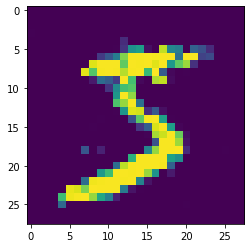

In [6]:
logits, mu, logscale = model(dataset.data[0].reshape(1, 1, 28, 28).to(device).float())
sample = discretized_mol_sampling(logits, mu, logscale).reshape(28, 28).cpu().detach()
plt.imshow(sample)
plt.show()

In [7]:
testdataset = datasets.MNIST(root='./mnist_data/', train=False, download=True).data.float() / 255.0

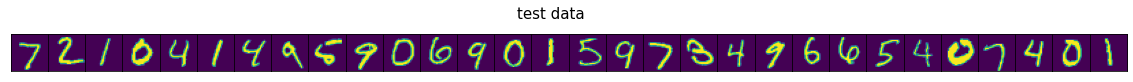

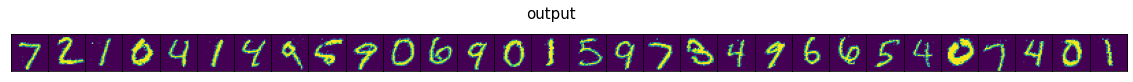

_


<Figure size 1440x144 with 0 Axes>

In [8]:
num_image = 30

fig = plt.figure(figsize=(20, 2))

n = 0
for i in range(num_image):
    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(testdataset[n])
    n += 1
fig.suptitle('test data', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
fig = plt.figure(figsize=(20, 2))

model.eval()
n = 0
for i in range(num_image):
    x_q = testdataset[n].reshape(1, 1, 28, 28).float().to(device)
    logits, mu, logscale = model(x_q)
    x_p = discretized_mol_sampling(logits, mu, logscale).reshape(28, 28).cpu().detach()
    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(x_p.cpu().data.numpy().reshape(28, 28))
    n += 1
model.train()
fig.suptitle('output', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()
fig = plt.figure(figsize=(20, 2))

model.eval()
print('_')

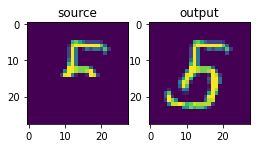

_


In [9]:
f = plt.figure(figsize=(4,2))
ax = f.add_subplot(1,2,1)


input = testdataset[45].reshape(1, 1, 28, 28).float().clone()
input[0, 0, 15:28, :] = 0.0
ax.imshow(input.reshape(28, 28))
ax.set_title('source')

model.eval()
x_q = input.to(device)
with torch.no_grad():
    for h in range(15, 28):
        for w in range(28):
            logits, mu, logscale = model(x_q)
            x_p = discretized_mol_sampling(logits, mu, logscale).cpu().detach()  
            x_q[0][0][h][w] = x_p[0][0][h][w]


model.train()


ax = f.add_subplot(1,2,2)
ax.imshow(x_q.cpu().data.numpy().reshape(28, 28))
ax.set_title('output')
plt.show()


print('_')

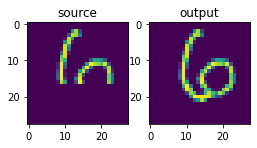

_


In [15]:
f = plt.figure(figsize=(4,2))
ax = f.add_subplot(1,2,1)


input = testdataset[100].reshape(1, 1, 28, 28).float().clone()
input[0, 0, 17:28, :] = 0.0
ax.imshow(input.reshape(28, 28))
ax.set_title('source')

model.eval()
x_q = input.to(device)
with torch.no_grad():
    for h in range(17, 28):
        for w in range(28):
            logits, mu, logscale = model(x_q)
            x_p = discretized_mol_sampling(logits, mu, logscale).cpu().detach()  
            x_q[0][0][h][w] = x_p[0][0][h][w]


model.train()


ax = f.add_subplot(1,2,2)
ax.imshow(x_q.cpu().data.numpy().reshape(28, 28))
ax.set_title('output')
plt.show()


print('_')